In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# **Trial-by-trial Analysis of SCR and brain response for shock**

In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)

In [2]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
SCR_betapath = join(eCON,'SCR_new/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/shock_IM/{subj}_bucket_REML_clean.1D')
roi_betapath = join(eCON,'dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_{roi}/noProx/shock_IM/{subj}_bucket_REML.1D')
yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [3]:
rois = 'rvAI rdAI lvAI ldAI rPI lPI rBNST lBNST ACC\
        Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L\
        rCa lCa rPa lPa rVS lVS vmPFC PCC1 PCC2 rPAG1 lPAG1'.split()

#rois = 'Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L lPa rVS lVS'.split()

#rois = 'lBNST rBNST'.split()

24

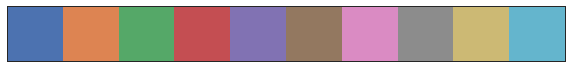

In [4]:
pal = sns.color_palette()
sns.palplot(pal)
len(rois)

In [5]:
count = 0
df = pd.DataFrame()
for i, row in yoked.iterrows():
    for kind in ['control','uncontrol']:
        #print(row[kind])
        scr_beta = np.loadtxt(SCR_betapath.format(subj=row[kind],group=kind))[25::2]
        roi_beta = np.vstack([np.loadtxt(roi_betapath.format(subj=row[kind],roi=roi,group=kind))[25::2] for roi in rois]).T
        all_betas = np.concatenate((scr_beta[:,None],roi_beta),axis=1)

        tmp_df = pd.DataFrame(all_betas,columns=['SCR']+rois)
        tmp_df['SubjID'] = row[kind]
        tmp_df['Group'] = kind
        tmp_df['Pair'] = 'P{:02d}'.format(i)
        df = pd.concat([df,tmp_df],axis =0)

## **ROI shock response vs. SCR shock response**

In [6]:
cmap = plt.get_cmap('Set1')
def plot_SCR_ROI_corr(roi):
    fig = plt.figure(figsize=(8,6))
    sns.regplot('SCR',roi,df[df['Group']=='uncontrol'],color=cmap.colors[0],
                scatter_kws={'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[0]},label='uncontrol')
    sns.regplot('SCR',roi,df[df['Group']=='control'],color=cmap.colors[1],
                scatter_kws= {'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[1]},label='control')
    plt.xlabel('Skin Conductance\n[Shock] (A.U.)')
    plt.ylabel('{}\n[Shock] (A.U.)'.format(roi))
    plt.legend()
    #plt.savefig(join(eCON,'scripts/tmp_preproc2/figures/{}_SCR_correlation.png').format(roi),dpi=600)

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


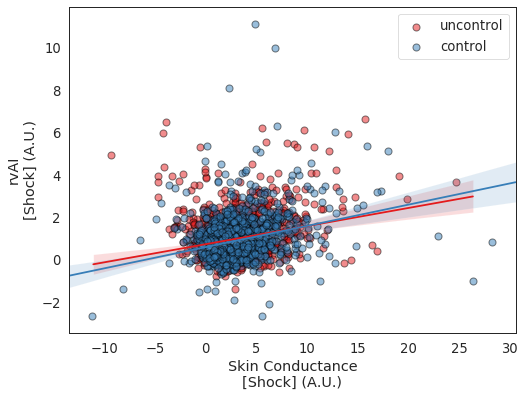

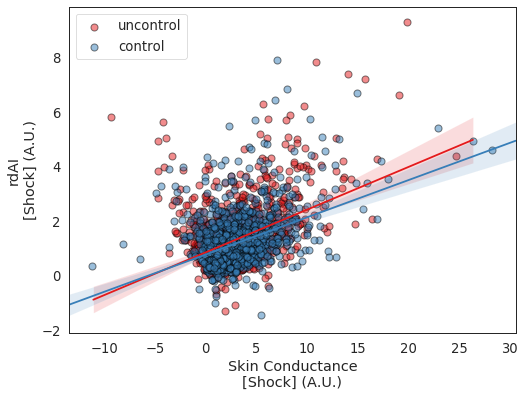

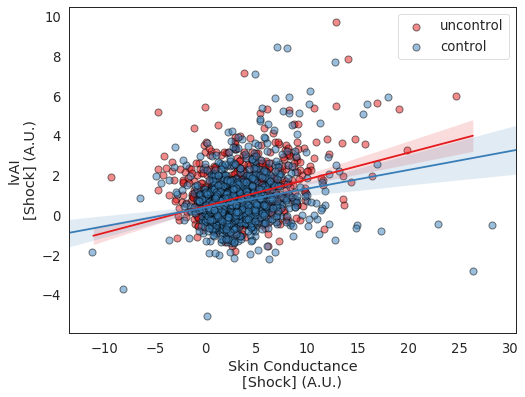

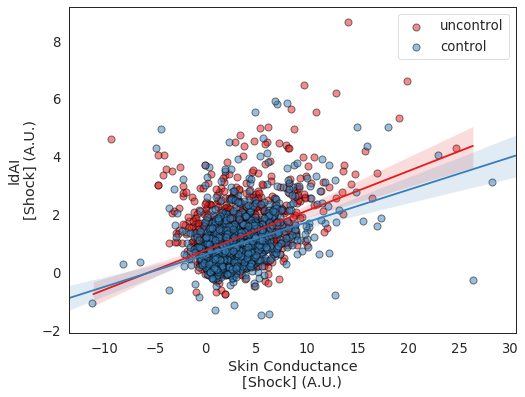

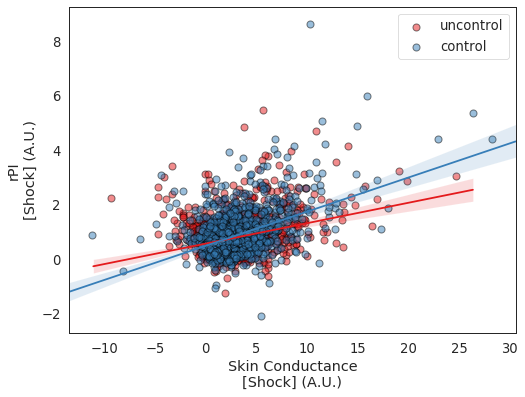

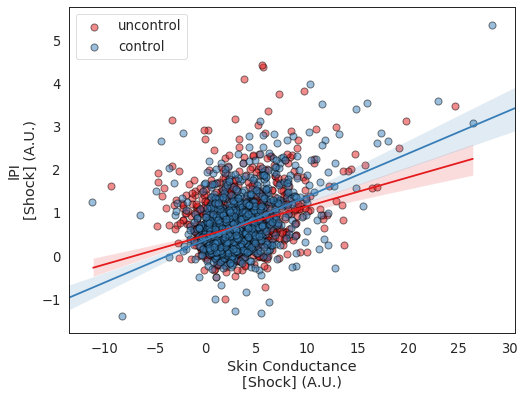

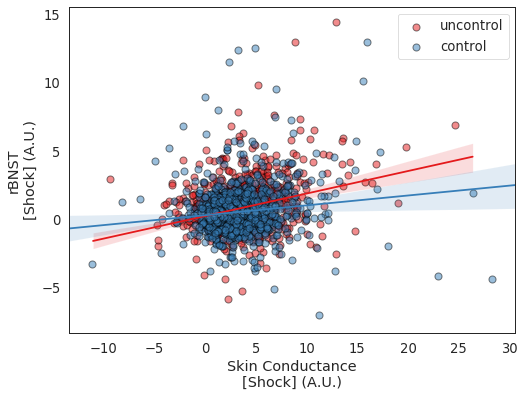

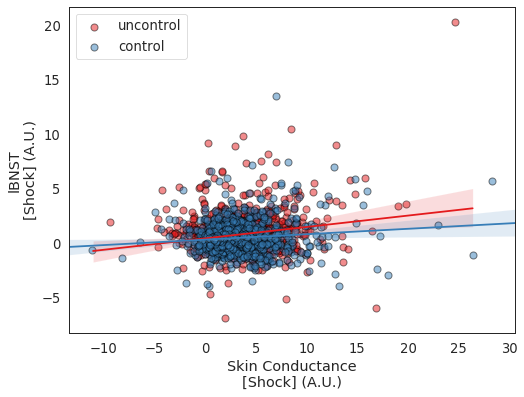

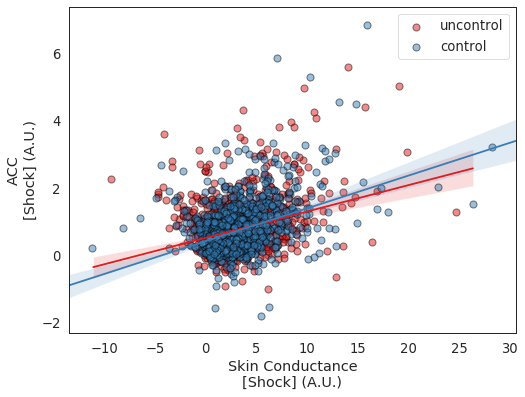

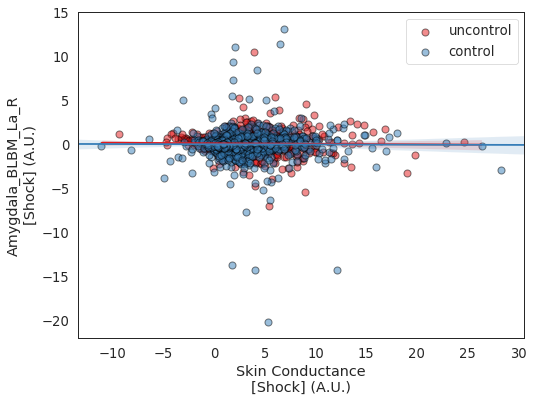

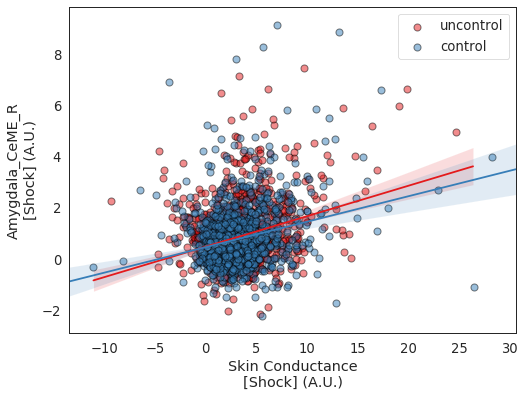

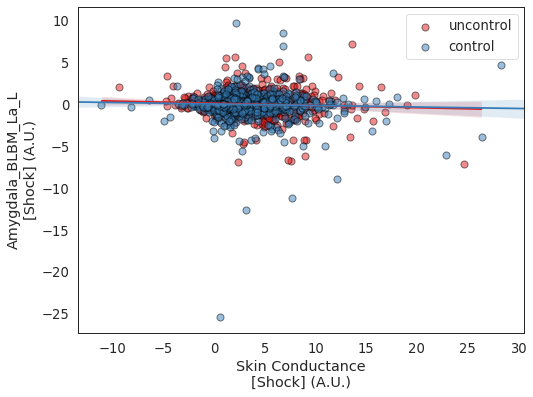

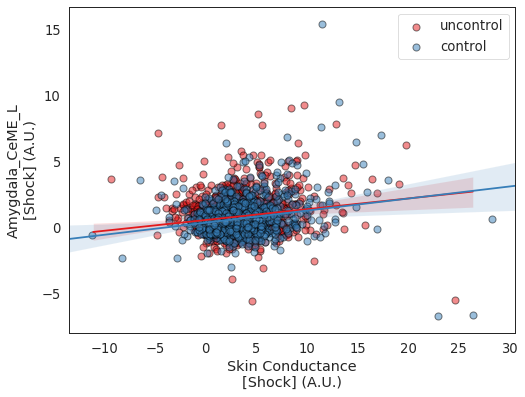

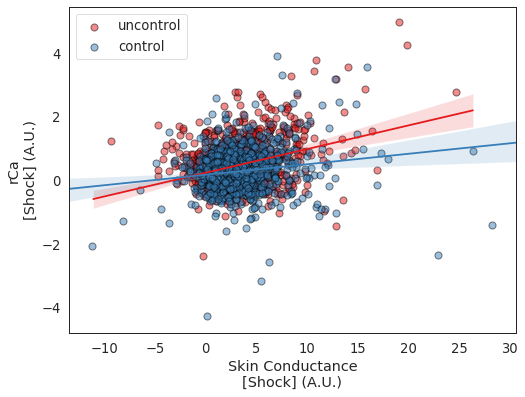

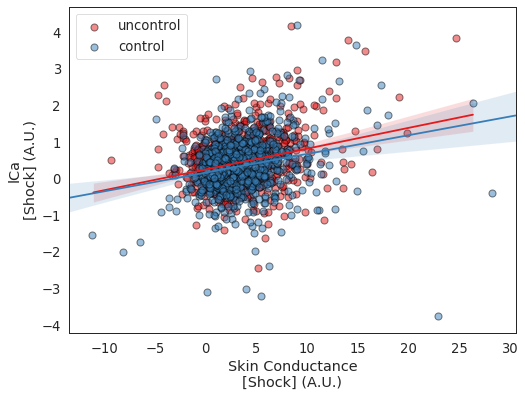

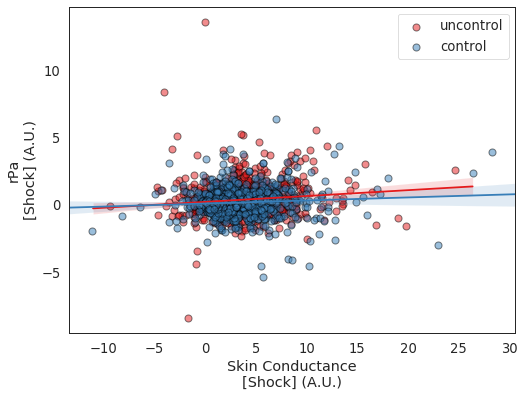

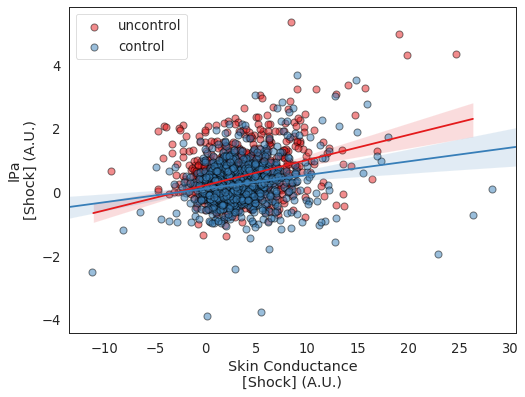

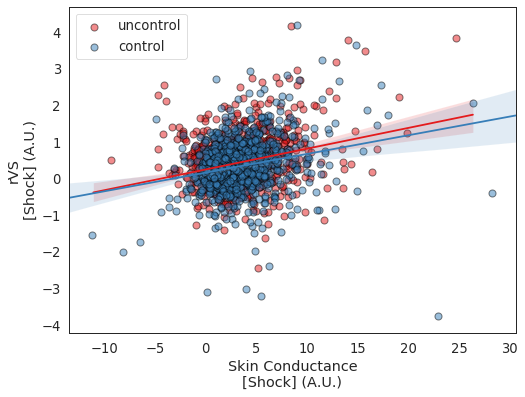

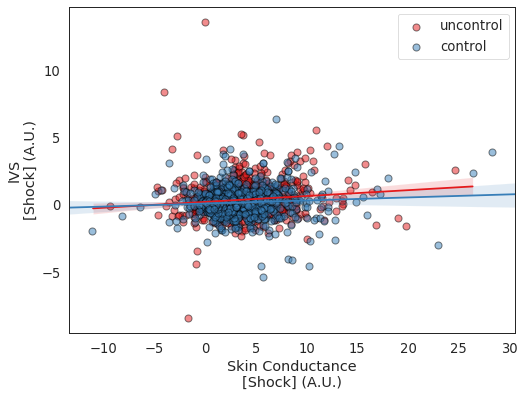

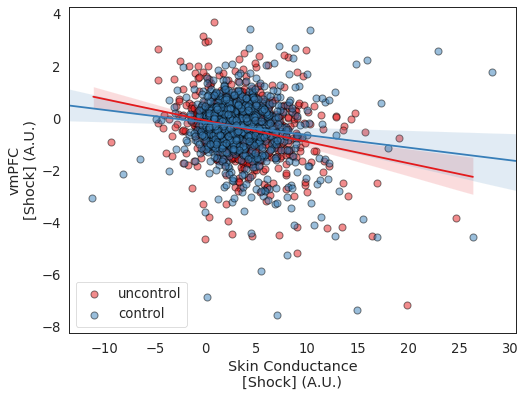

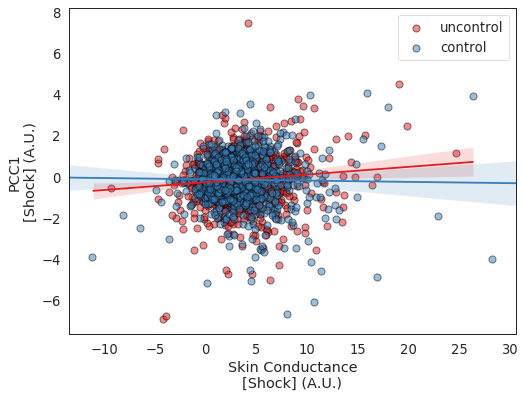

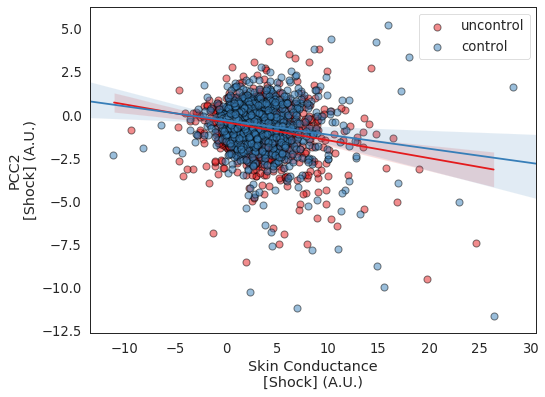

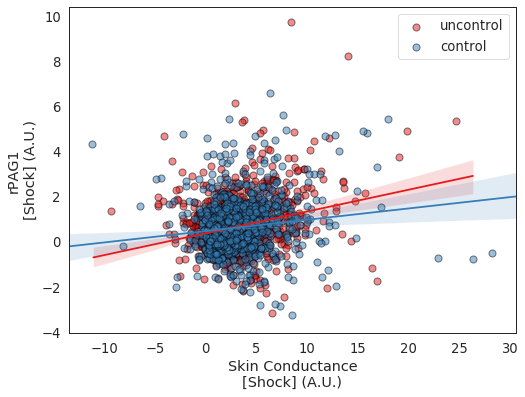

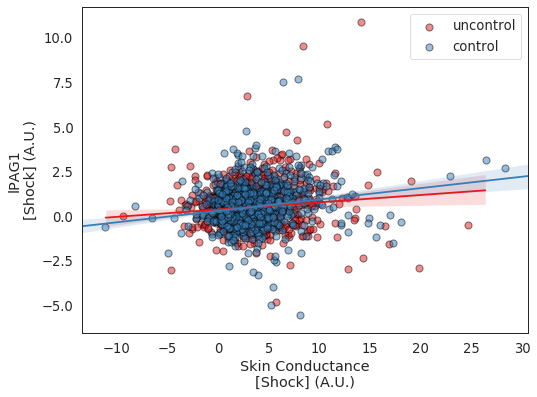

In [20]:
_=[plot_SCR_ROI_corr(roi) for roi in rois]

## **Standard paired t-tests for each ROI**

In [8]:
from scipy.stats import pearsonr, spearmanr, ttest_rel, ttest_1samp
import math

In [9]:
def ttest_SCR_roi(roi):
    con = []; uncon = []
    for i, row in yoked.iterrows():
        con_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')][roi].values
        uncon_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')][roi].values

        con_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')]['SCR'].values
        uncon_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')]['SCR'].values

        con_rp,_ = pearsonr(con_roi,con_SCR)
        uncon_rp,_ = pearsonr(uncon_roi,uncon_SCR)

        con_zp = math.atanh(con_rp)
        uncon_zp = math.atanh(uncon_rp)

        con.append(con_zp); uncon.append(uncon_zp)
        
    print(roi,': t = %.4f, p = %.4f' %(ttest_1samp(np.subtract(uncon,con),0)))

In [10]:
print([ttest_SCR_roi(roi) for roi in rois])

rvAI : t = 0.3479, p = 0.7292
rdAI : t = 0.6232, p = 0.5357
lvAI : t = 0.9848, p = 0.3290
ldAI : t = 0.7211, p = 0.4738
rPI : t = 0.0819, p = 0.9350
lPI : t = -0.0163, p = 0.9870
rBNST : t = 2.4714, p = 0.0165
lBNST : t = 1.9189, p = 0.0601
ACC : t = 0.1675, p = 0.8676
Amygdala_BLBM_La_R : t = -0.9422, p = 0.3501
Amygdala_CeME_R : t = 1.9133, p = 0.0608
Amygdala_BLBM_La_L : t = -0.6000, p = 0.5509
Amygdala_CeME_L : t = -0.0670, p = 0.9468
rCa : t = 2.2911, p = 0.0257
lCa : t = 0.5554, p = 0.5809
rPa : t = 0.6814, p = 0.4984
lPa : t = 1.7269, p = 0.0897
rVS : t = 0.5554, p = 0.5809
lVS : t = 0.6814, p = 0.4984
vmPFC : t = -0.1096, p = 0.9131
PCC1 : t = 0.2288, p = 0.8199
PCC2 : t = -0.9251, p = 0.3589
rPAG1 : t = 1.5615, p = 0.1240
lPAG1 : t = -1.6530, p = 0.1039
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [11]:
def get_zcorr_df(roi):
    rba_df = pd.DataFrame()
    for roi in rois:
        for i, row in yoked.iterrows():
            con_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')][roi].values
            uncon_roi = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')][roi].values

            con_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='control')]['SCR'].values
            uncon_SCR = df[(df['Pair']=='P{:02d}'.format(i)) & (df['Group']=='uncontrol')]['SCR'].values

            con_rp,_ = pearsonr(con_roi,con_SCR)
            uncon_rp,_ = pearsonr(uncon_roi,uncon_SCR)

            con_zp = math.atanh(con_rp)
            uncon_zp = math.atanh(uncon_rp)

            #con.append(con_zp); uncon.append(uncon_zp)

            tmp_df = pd.DataFrame(['P{:02}'.format(i), roi, uncon_zp-con_zp],index=['Subj','ROI','Y']).T
            rba_df = pd.concat([rba_df,tmp_df],axis=0)

    return rba_df
    #print(roi,':',ttest_1samp(np.subtract(uncon,con),0))

In [12]:
rba_df = get_zcorr_df(rois)

In [13]:
rba_df.set_index(['Subj','ROI'],inplace=True)

## **RBA dataset**
first few entries

In [14]:
rba_df.head()

,,Y
Subj,ROI,
P00,rvAI,-0.775176
P01,rvAI,0.924895
P02,rvAI,-0.0899713
P03,rvAI,-0.547873
P04,rvAI,0.00449203


In [15]:
cov_df = pd.read_csv(join(eCON,'dataset/data_for_RBA/uncon_v_con_ROI24_with_covariates.txt'),sep='\t',index_col=['Subj','ROI'])

In [16]:
cov_df.drop(columns='Y',inplace=True)

TRAITmean  TRAITdiff  STATEmean  STATEdiff
Subj ROI                                              
P00  vmPFC     -1.003    -0.0406    -1.2307    -0.1812
     PCC1      -1.003    -0.0406    -1.2307    -0.1812
     PCC2      -1.003    -0.0406    -1.2307    -0.1812
     rPAG1     -1.003    -0.0406    -1.2307    -0.1812
     lPAG1     -1.003    -0.0406    -1.2307    -0.1812

In [17]:
rba_df = rba_df.join(cov_df).reset_index()
rba_df['Y'] = rba_df['Y'].astype(float)

## **RBA dataset with covariates**
first few entries

In [18]:
rba_df.to_csv(join(eCON,'dataset/data_for_RBA/uncon_v_con_ROI24_shock_SCR_corr_z.txt'),sep='\t',index=False,float_format='%.4f')
rba_df.head()

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff
0,P00,rvAI,-0.775176,-1.0030,-0.0406,-1.2307,-0.1812
1,P01,rvAI,0.924895,-0.4359,3.1472,-0.4379,0.4163
2,P02,rvAI,-0.089971,0.1942,0.3136,-0.5172,0.3167
3,P03,rvAI,-0.547873,-1.5702,1.0220,-1.6270,-0.0816
4,P04,rvAI,0.004492,-0.2469,-0.0406,-0.2794,0.6155


In [19]:
rba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 7 columns):
Subj         1368 non-null object
ROI          1368 non-null object
Y            1368 non-null float64
TRAITmean    1368 non-null float64
TRAITdiff    1368 non-null float64
STATEmean    1368 non-null float64
STATEdiff    1368 non-null float64
dtypes: float64(5), object(2)
memory usage: 74.9+ KB
